# Exploratory Data Analysis (EDA)

### Objective
1. Fix ALL state name inconsistencies (68 → ~36)
2. Create visualizations
3. Find interesting patterns and trends
4. Discover insights


---

### Import Libraries and Load Cleaned Data

In [15]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Colors for our charts
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported!")

 Libraries imported!


In [16]:
# Load cleaned data
print(" Loading cleaned datasets...")

enrolment_df = pd.read_csv('../processed_data/enrolment_cleaned.csv')
demographic_df = pd.read_csv('../processed_data/demographic_cleaned.csv')
biometric_df = pd.read_csv('../processed_data/biometric_cleaned.csv')

# Convert date back to datetime
enrolment_df['date'] = pd.to_datetime(enrolment_df['date'])
demographic_df['date'] = pd.to_datetime(demographic_df['date'])
biometric_df['date'] = pd.to_datetime(biometric_df['date'])

print(f" Enrolment: {len(enrolment_df):,} rows")
print(f" Demographic: {len(demographic_df):,} rows")
print(f" Biometric: {len(biometric_df):,} rows")

# Show unique states BEFORE fixing
all_states_before = sorted(set(enrolment_df['state'].unique()) | 
                           set(demographic_df['state'].unique()) | 
                           set(biometric_df['state'].unique()))
print(f"\n⚠ Total unique 'state' values BEFORE cleaning: {len(all_states_before)}")
print("   (India has only ~36 states/UTs - so we have problems!)")

 Loading cleaned datasets...
 Enrolment: 1,006,029 rows
 Demographic: 2,071,700 rows
 Biometric: 1,861,108 rows

⚠ Total unique 'state' values BEFORE cleaning: 68
   (India has only ~36 states/UTs - so we have problems!)


## Fix ALL State Name Inconsistencies

**Problem Found:** We have 68 unique values but India only has 36 states/UTs!

**Types of Problems:**
1. **CASE variations** - West Bengal, WEST BENGAL, West bengal
2. **Spelling mistakes** - West Bangal, West Bengli, Chhatisgarh
3. **Old names** - Orissa (now Odisha), Uttaranchal (now Uttarakhand)
4. **& vs 'and'** - Jammu & Kashmir vs Jammu and Kashmir
5. **Spacing issues** - 'West  Bengal' (double space), WESTBENGAL (no space)
6. **City names as states** - Jaipur, Nagpur, Darbhanga (DATA ENTRY ERRORS)
7. **Invalid data** - '100000' (looks like pincode)

In [17]:
# COMPLETE mapping to fix ALL state name inconsistencies
state_corrections = {
    # ========== WEST BENGAL VARIATIONS (8 wrong versions!) ==========
    'WEST BENGAL': 'West Bengal',
    'WESTBENGAL': 'West Bengal',
    'West  Bengal': 'West Bengal',  # Double space
    'West Bangal': 'West Bengal',   # Spelling mistake
    'West bengal': 'West Bengal',   # lowercase
    'Westbengal': 'West Bengal',    # No space
    'west Bengal': 'West Bengal',   # lowercase first word
    'West Bengli': 'West Bengal',   # Spelling mistake
    
    # ========== ODISHA VARIATIONS (3 variations) ==========
    'ODISHA': 'Odisha',
    'Orissa': 'Odisha',             # Old name (changed in 2011)
    'odisha': 'Odisha',             # lowercase
    
    # ========== ANDHRA PRADESH ==========
    'andhra pradesh': 'Andhra Pradesh',  # lowercase
    
    # ========== TAMIL NADU ==========
    'Tamilnadu': 'Tamil Nadu',      # No space
    
    # ========== JAMMU & KASHMIR (2 variations) ==========
    'Jammu & Kashmir': 'Jammu and Kashmir',
    'Jammu And Kashmir': 'Jammu and Kashmir',  # Title case 'And'
    
    # ========== ANDAMAN & NICOBAR ==========
    'Andaman & Nicobar Islands': 'Andaman and Nicobar Islands',
    
    # ========== DADRA & NAGAR HAVELI (3 variations) ==========
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli',
    'Dadra and Nagar Haveli and Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    
    # ========== DAMAN & DIU ==========
    'Daman & Diu': 'Daman and Diu',
    
    # ========== PUDUCHERRY (Old name) ==========
    'Pondicherry': 'Puducherry',    # Old name (renamed in 2006)
    
    # ========== CHHATTISGARH (Spelling) ==========
    'Chhatisgarh': 'Chhattisgarh',  # Missing 't'
    
    # ========== UTTARAKHAND (Old name) ==========
    'Uttaranchal': 'Uttarakhand'    # Old name (changed in 2007)
}

print(f" Created {len(state_corrections)} state name corrections")
print("\n Categories of corrections:")
print("   • 8 West Bengal variations")
print("   • 3 Odisha variations (including old name 'Orissa')")
print("   • 1 Andhra Pradesh lowercase fix")
print("   • 1 Tamil Nadu spacing fix")
print("   • 2 Jammu & Kashmir variations")
print("   • 1 Andaman & Nicobar Islands")
print("   • 3 Dadra and Nagar Haveli variations")
print("   • 1 Daman & Diu")
print("   • 1 Pondicherry → Puducherry (old name)")
print("   • 1 Chhatisgarh → Chhattisgarh (spelling)")
print("   • 1 Uttaranchal → Uttarakhand (old name)")

 Created 23 state name corrections

 Categories of corrections:
   • 8 West Bengal variations
   • 3 Odisha variations (including old name 'Orissa')
   • 1 Andhra Pradesh lowercase fix
   • 1 Tamil Nadu spacing fix
   • 2 Jammu & Kashmir variations
   • 1 Andaman & Nicobar Islands
   • 3 Dadra and Nagar Haveli variations
   • 1 Daman & Diu
   • 1 Pondicherry → Puducherry (old name)
   • 1 Chhatisgarh → Chhattisgarh (spelling)
   • 1 Uttaranchal → Uttarakhand (old name)


In [18]:
# Apply corrections to all datasets
def fix_state_names(df, corrections):
    df['state'] = df['state'].replace(corrections)
    return df

print("Applying corrections...")
enrolment_df = fix_state_names(enrolment_df, state_corrections)
demographic_df = fix_state_names(demographic_df, state_corrections)
biometric_df = fix_state_names(biometric_df, state_corrections)
print(" Name corrections applied!")

Applying corrections...
 Name corrections applied!


In [19]:
# Remove INVALID entries (city names, pincodes entered as states - DATA ERRORS)
invalid_states = [
    '100000',              # Looks like a pincode
    'BALANAGAR',           # Locality in Hyderabad
    'Darbhanga',           # District in Bihar
    'Jaipur',              # City in Rajasthan
    'Madanapalle',         # Town in Andhra Pradesh
    'Nagpur',              # City in Maharashtra
    'Puttenahalli',        # Locality in Bangalore
    'Raja Annamalai Puram' # Locality in Chennai
]

print("🗑 Removing invalid entries (data entry errors):")
for inv in invalid_states:
    count_enrol = len(enrolment_df[enrolment_df['state'] == inv])
    count_demo = len(demographic_df[demographic_df['state'] == inv])
    count_bio = len(biometric_df[biometric_df['state'] == inv])
    total = count_enrol + count_demo + count_bio
    if total > 0:
        print(f"   • '{inv}': {total} rows removed")

# Remove invalid entries
enrolment_df = enrolment_df[~enrolment_df['state'].isin(invalid_states)]
demographic_df = demographic_df[~demographic_df['state'].isin(invalid_states)]
biometric_df = biometric_df[~biometric_df['state'].isin(invalid_states)]

print("\n Invalid entries removed!")

🗑 Removing invalid entries (data entry errors):
   • '100000': 24 rows removed
   • 'BALANAGAR': 2 rows removed
   • 'Darbhanga': 2 rows removed
   • 'Jaipur': 2 rows removed
   • 'Madanapalle': 2 rows removed
   • 'Nagpur': 1 rows removed
   • 'Puttenahalli': 1 rows removed
   • 'Raja Annamalai Puram': 1 rows removed

 Invalid entries removed!


In [20]:
# Verify the fix - count unique states now
print("="*60)
print(" AFTER CLEANING - STATE COUNTS")
print("="*60)
print(f"\nUnique states in Enrolment: {enrolment_df['state'].nunique()}")
print(f"Unique states in Demographic: {demographic_df['state'].nunique()}")
print(f"Unique states in Biometric: {biometric_df['state'].nunique()}")

# Show all cleaned states
all_clean_states = sorted(set(enrolment_df['state'].unique()) | 
                          set(demographic_df['state'].unique()) | 
                          set(biometric_df['state'].unique()))
print(f"\n Total unique states/UTs after cleaning: {len(all_clean_states)}")
print(f"   (Reduced from {len(all_states_before)} to {len(all_clean_states)}!)")
print("\nAll states/UTs:")
for i, state in enumerate(all_clean_states, 1):
    print(f"   {i:2}. {state}")

 AFTER CLEANING - STATE COUNTS

Unique states in Enrolment: 38
Unique states in Demographic: 38
Unique states in Biometric: 38

 Total unique states/UTs after cleaning: 38
   (Reduced from 68 to 38!)

All states/UTs:
    1. Andaman and Nicobar Islands
    2. Andhra Pradesh
    3. Arunachal Pradesh
    4. Assam
    5. Bihar
    6. Chandigarh
    7. Chhattisgarh
    8. Dadra and Nagar Haveli
    9. Dadra and Nagar Haveli and Daman and Diu
   10. Daman and Diu
   11. Delhi
   12. Goa
   13. Gujarat
   14. Haryana
   15. Himachal Pradesh
   16. Jammu and Kashmir
   17. Jharkhand
   18. Karnataka
   19. Kerala
   20. Ladakh
   21. Lakshadweep
   22. Madhya Pradesh
   23. Maharashtra
   24. Manipur
   25. Meghalaya
   26. Mizoram
   27. Nagaland
   28. Odisha
   29. Puducherry
   30. Punjab
   31. Rajasthan
   32. Sikkim
   33. Tamil Nadu
   34. Telangana
   35. Tripura
   36. Uttar Pradesh
   37. Uttarakhand
   38. West Bengal



## VISUALIZATIONS - Finding Interesting Patterns!

### Visualization 1: Top 10 States by Enrolment

**Question:** Which states have the most Aadhaar enrolments?

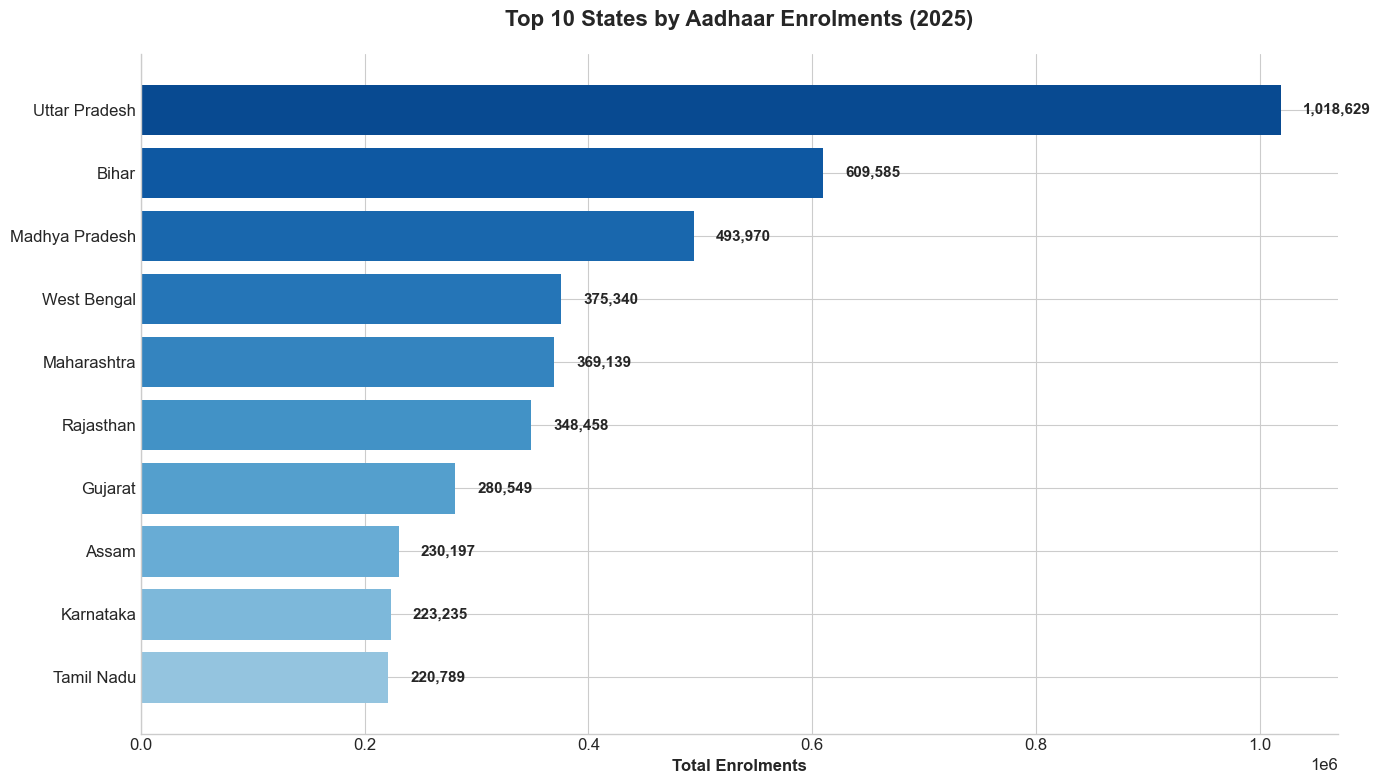


💡 INSIGHT: Uttar Pradesh leads with the highest enrolments, followed by Bihar and Madhya Pradesh.
   This correlates with population - more people = more enrolments!


In [21]:
# Calculate total enrolments per state
state_enrolment = enrolment_df.groupby('state')['total_enrolled'].sum().sort_values(ascending=False)

# Create a beautiful bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Get top 10 states
top_10 = state_enrolment.head(10)

# Create bar chart with gradient colors
bars = ax.barh(range(len(top_10)), top_10.values, color=plt.cm.Blues(np.linspace(0.4, 0.9, len(top_10)))[::-1])

# Add state names
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10.index)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_10.values)):
    ax.text(value + 20000, i, f'{value:,.0f}', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Total Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Top 10 States by Aadhaar Enrolments (2025)', fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()  # Highest on top
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../results/figures/top_10_states_enrolment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Uttar Pradesh leads with the highest enrolments, followed by Bihar and Madhya Pradesh.")
print("   This correlates with population - more people = more enrolments!")

### Visualization 2: Monthly Trend of Enrolments

**Question:** How do enrolments change over months? Are there any patterns?

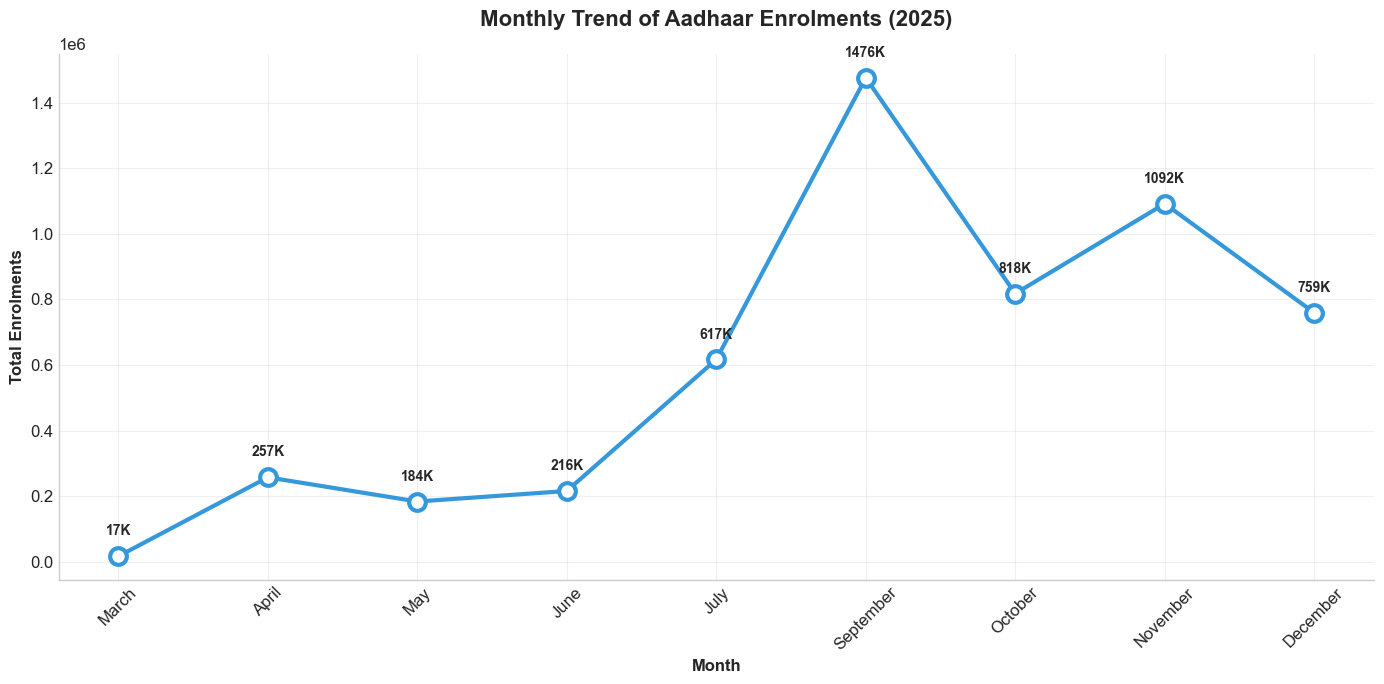


💡 INSIGHT: Peak enrolment month: September (1,475,867)
   Lowest enrolment month: March (16,582)


In [22]:
# Group by month and calculate total enrolments
monthly_enrolment = enrolment_df.groupby('month_name')['total_enrolled'].sum()

# Define correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Reorder months
monthly_enrolment = monthly_enrolment.reindex([m for m in month_order if m in monthly_enrolment.index])

# Create line chart
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(monthly_enrolment.index, monthly_enrolment.values, 
        marker='o', markersize=12, linewidth=3, color='#3498db', markerfacecolor='white', markeredgewidth=3)

# Add value labels
for i, (month, value) in enumerate(monthly_enrolment.items()):
    ax.annotate(f'{value/1000:.0f}K', (i, value), textcoords="offset points", 
                xytext=(0, 15), ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Monthly Trend of Aadhaar Enrolments (2025)', fontsize=16, fontweight='bold', pad=20)
ax.tick_params(axis='x', rotation=45)

# Add grid
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../results/figures/monthly_enrolment_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Find peak and low months
peak_month = monthly_enrolment.idxmax()
low_month = monthly_enrolment.idxmin()
print(f"\n💡 INSIGHT: Peak enrolment month: {peak_month} ({monthly_enrolment[peak_month]:,})")
print(f"   Lowest enrolment month: {low_month} ({monthly_enrolment[low_month]:,})")

### Visualization 3: Age Group Distribution in Enrolments

**Question:** Which age group gets enrolled the most - children or adults?

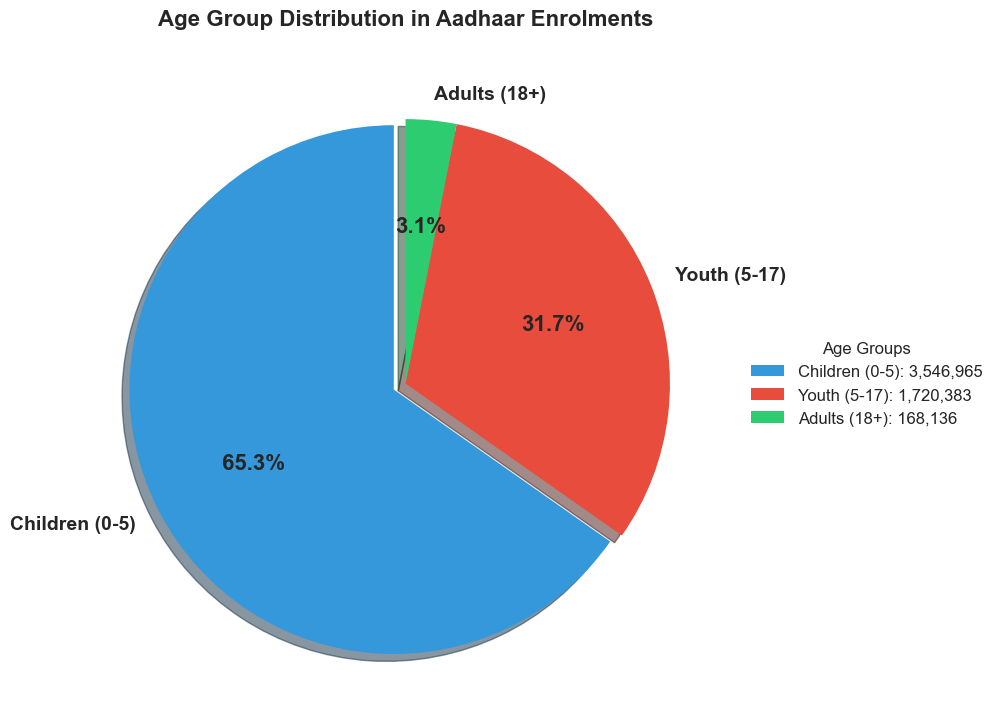


💡 INSIGHT: Children (0-5 years) have the HIGHEST enrolments!
   This makes sense as newborns are getting their first Aadhaar.
   Adults (18+) have the lowest because most adults already have Aadhaar.


In [23]:
# Calculate totals for each age group
age_groups = {
    'Children (0-5)': enrolment_df['age_0_5'].sum(),
    'Youth (5-17)': enrolment_df['age_5_17'].sum(),
    'Adults (18+)': enrolment_df['age_18_greater'].sum()
}

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 10))

colors_pie = ['#3498db', '#e74c3c', '#2ecc71']
explode = (0.05, 0, 0)  # Explode the first slice (children)

wedges, texts, autotexts = ax.pie(age_groups.values(), labels=age_groups.keys(), autopct='%1.1f%%',
                                   colors=colors_pie, explode=explode, shadow=True, startangle=90,
                                   textprops={'fontsize': 14, 'fontweight': 'bold'})

# Make percentage text bold
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(16)

ax.set_title('Age Group Distribution in Aadhaar Enrolments', fontsize=16, fontweight='bold', pad=20)

# Add legend with actual numbers
legend_labels = [f"{k}: {v:,}" for k, v in age_groups.items()]
ax.legend(wedges, legend_labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig('../results/figures/age_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Children (0-5 years) have the HIGHEST enrolments!")
print("   This makes sense as newborns are getting their first Aadhaar.")
print("   Adults (18+) have the lowest because most adults already have Aadhaar.")

### Visualization 4: Weekday vs Weekend Comparison

**Question:** Do people enrol more on weekdays or weekends?

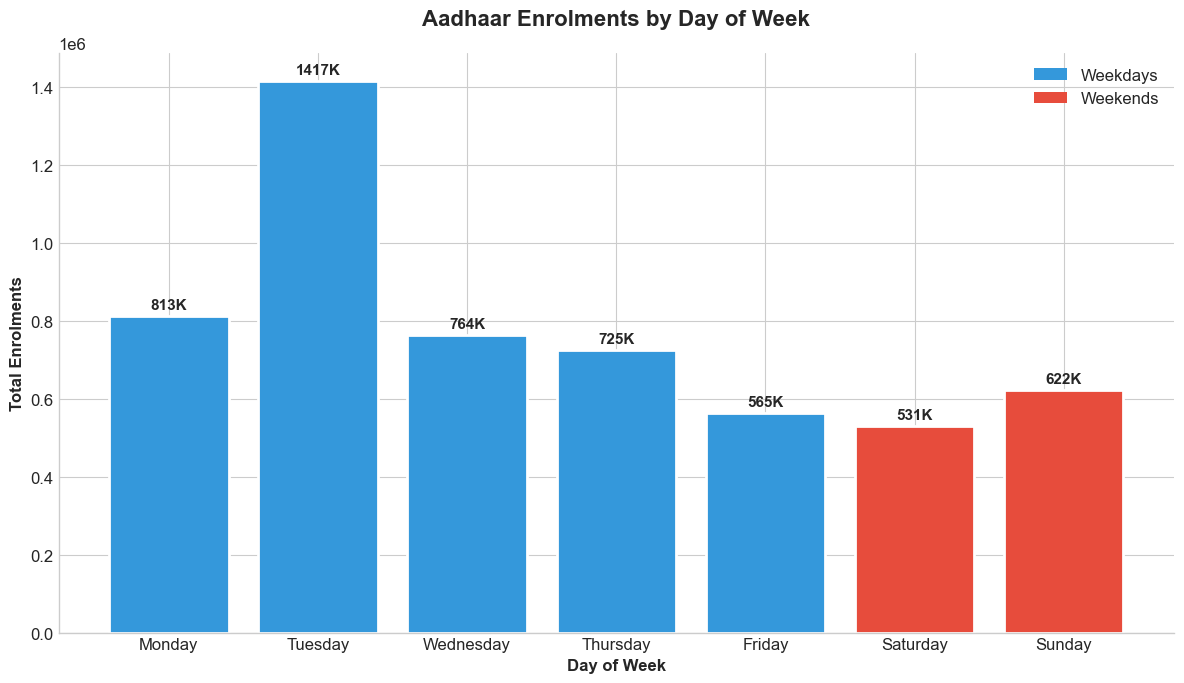


💡 INSIGHT: Weekday enrolments: 4,283,282 (78.8%)
   Weekend enrolments: 1,152,202 (21.2%)
   ➡ People enrol more on WEEKDAYS (possibly during office hours)


In [24]:
# Calculate enrolments by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_enrolment = enrolment_df.groupby('day_name')['total_enrolled'].sum()
daily_enrolment = daily_enrolment.reindex(day_order)

# Create bar chart with weekend highlighting
fig, ax = plt.subplots(figsize=(12, 7))

# Color weekdays and weekends differently
bar_colors = ['#3498db']*5 + ['#e74c3c']*2  # Blue for weekdays, red for weekends

bars = ax.bar(daily_enrolment.index, daily_enrolment.values, color=bar_colors, edgecolor='white', linewidth=2)

# Add value labels
for bar, value in zip(bars, daily_enrolment.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, 
            f'{value/1000:.0f}K', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Aadhaar Enrolments by Day of Week', fontsize=16, fontweight='bold', pad=20)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Weekdays'),
                   Patch(facecolor='#e74c3c', label='Weekends')]
ax.legend(handles=legend_elements, loc='upper right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../results/figures/weekday_vs_weekend.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate percentages
weekday_total = daily_enrolment[:5].sum()
weekend_total = daily_enrolment[5:].sum()
print(f"\n💡 INSIGHT: Weekday enrolments: {weekday_total:,} ({weekday_total/(weekday_total+weekend_total)*100:.1f}%)")
print(f"   Weekend enrolments: {weekend_total:,} ({weekend_total/(weekday_total+weekend_total)*100:.1f}%)")
print("   ➡ People enrol more on WEEKDAYS (possibly during office hours)")

### Visualization 5: Comparing Enrolment vs Updates

**Question:** How do new enrolments compare to updates (demographic + biometric)?

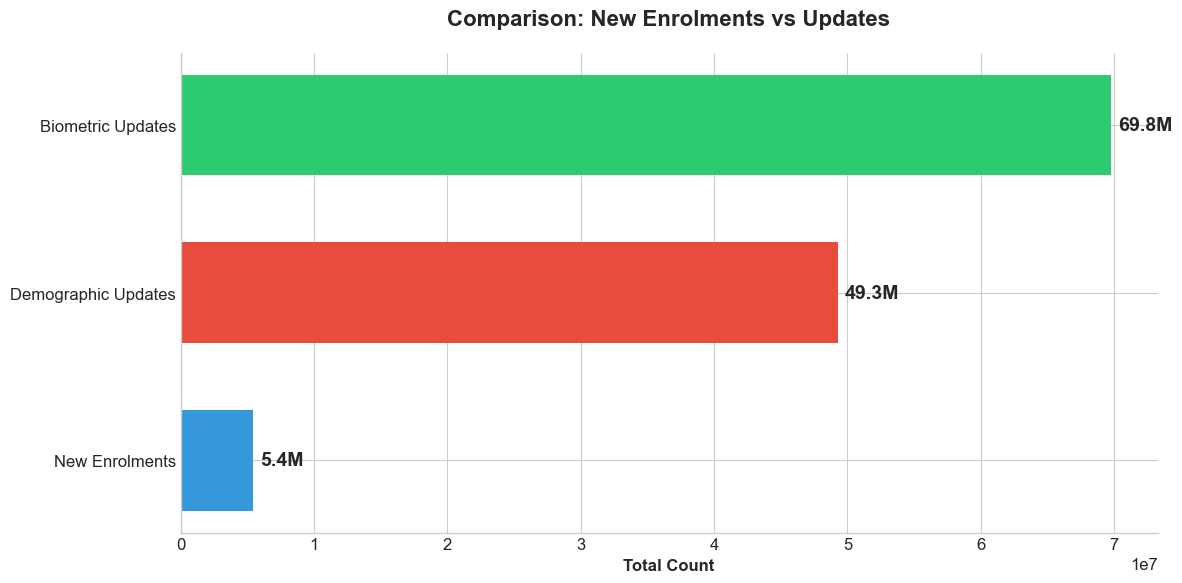


💡 INSIGHT: Biometric Updates are the HIGHEST!
   New Enrolments: 5.4 Million
   Demographic Updates: 49.3 Million
   Biometric Updates: 69.8 Million
   ➡ More people are updating biometrics than getting new Aadhaar!
   ➡ This could be due to mandatory biometric updates every 10 years.


In [25]:
# Calculate totals
comparison_data = {
    'New Enrolments': enrolment_df['total_enrolled'].sum(),
    'Demographic Updates': demographic_df['total_updates'].sum(),
    'Biometric Updates': biometric_df['total_updates'].sum()
}

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors_bar = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax.barh(list(comparison_data.keys()), list(comparison_data.values()), color=colors_bar, height=0.6)

# Add value labels
for bar, value in zip(bars, comparison_data.values()):
    ax.text(value + 500000, bar.get_y() + bar.get_height()/2, 
            f'{value/1000000:.1f}M', va='center', fontsize=14, fontweight='bold')

ax.set_xlabel('Total Count', fontsize=12, fontweight='bold')
ax.set_title('Comparison: New Enrolments vs Updates', fontsize=16, fontweight='bold', pad=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../results/figures/enrolment_vs_updates.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Biometric Updates are the HIGHEST!")
print(f"   New Enrolments: {comparison_data['New Enrolments']/1000000:.1f} Million")
print(f"   Demographic Updates: {comparison_data['Demographic Updates']/1000000:.1f} Million")
print(f"   Biometric Updates: {comparison_data['Biometric Updates']/1000000:.1f} Million")
print("   ➡ More people are updating biometrics than getting new Aadhaar!")
print("   ➡ This could be due to mandatory biometric updates every 10 years.")

### Visualization 6: Top 15 Districts by Enrolment

**Question:** Which districts have the highest enrolments?

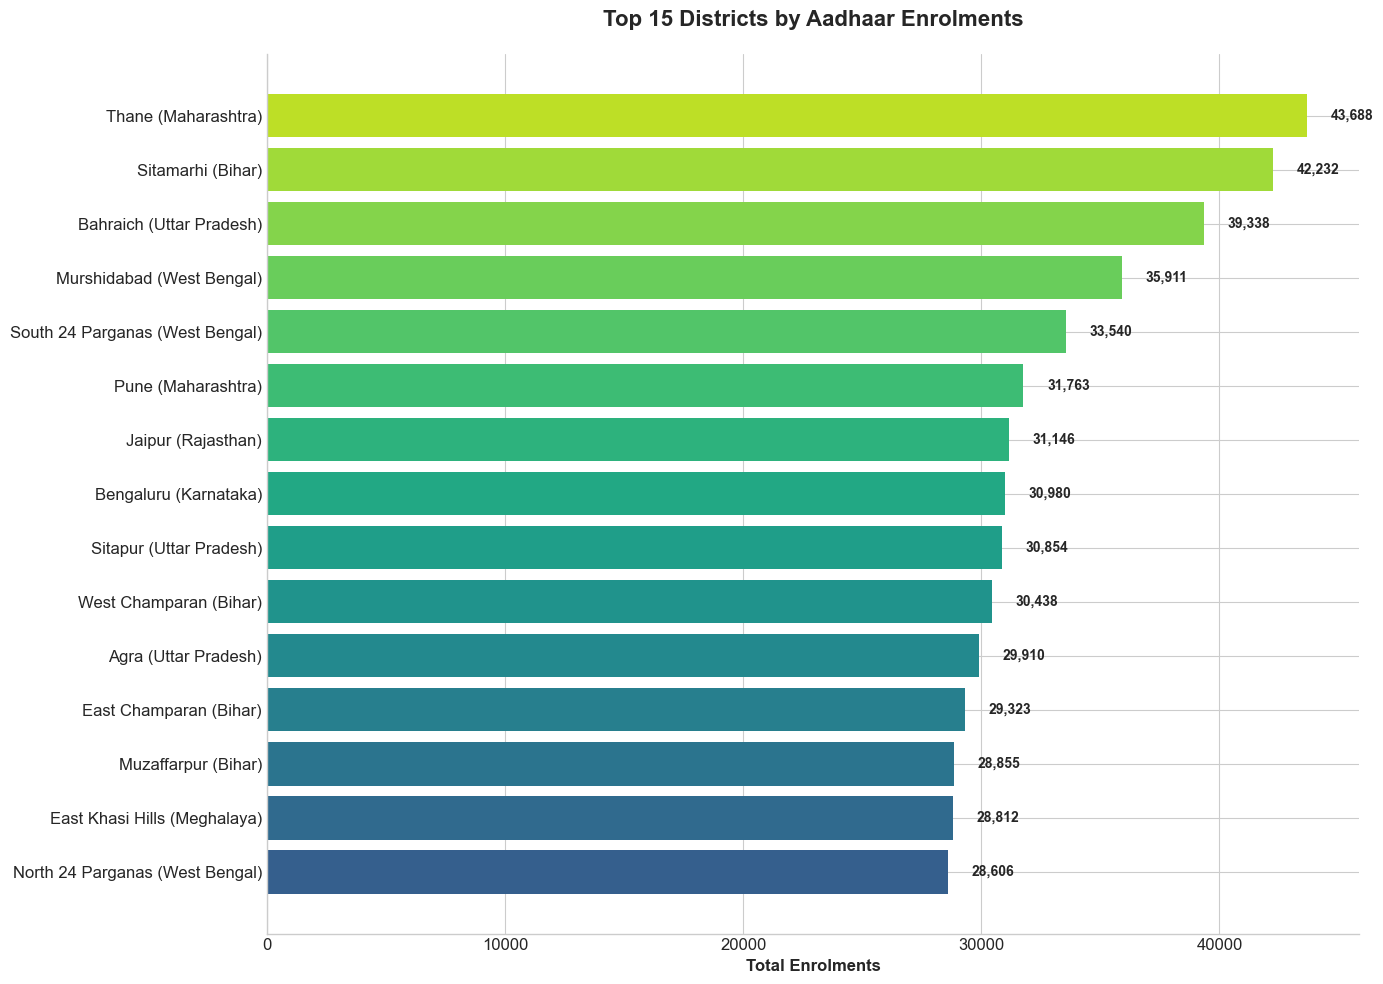


💡 INSIGHT: Large metro cities and densely populated districts lead in enrolments.


In [26]:
# Calculate enrolments per district
district_enrolment = enrolment_df.groupby(['state', 'district'])['total_enrolled'].sum().sort_values(ascending=False)

# Get top 15 districts
top_15_districts = district_enrolment.head(15)

# Create labels with state names
labels = [f"{district} ({state})" for (state, district) in top_15_districts.index]

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 10))

colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_15_districts)))
bars = ax.barh(range(len(top_15_districts)), top_15_districts.values, color=colors_grad[::-1])

ax.set_yticks(range(len(top_15_districts)))
ax.set_yticklabels(labels)

# Add value labels
for bar, value in zip(bars, top_15_districts.values):
    ax.text(value + 1000, bar.get_y() + bar.get_height()/2, 
            f'{value:,.0f}', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Total Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Districts by Aadhaar Enrolments', fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../results/figures/top_15_districts.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Large metro cities and densely populated districts lead in enrolments.")

### Visualization 7: Heatmap - Enrolments by State and Month

**Question:** Which states are most active in which months?

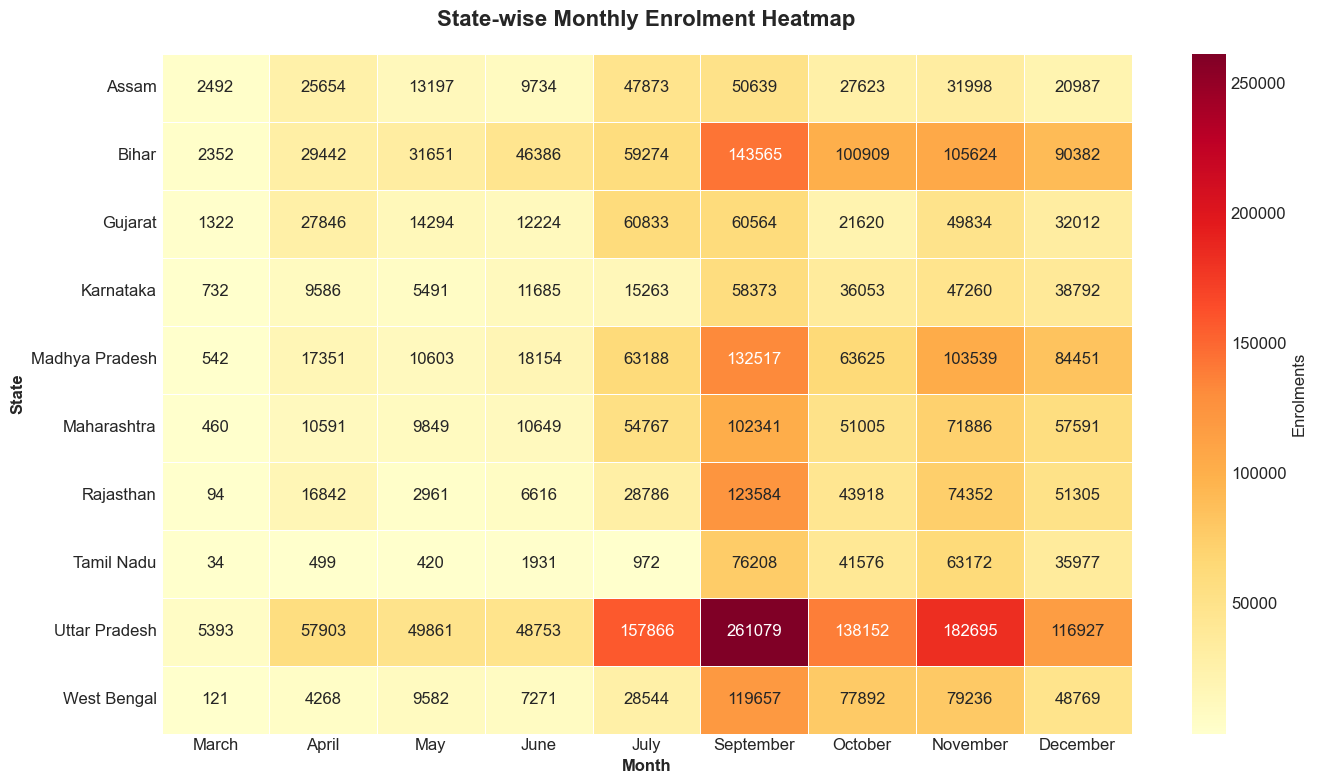


💡 INSIGHT: The heatmap shows which states are most active in specific months.
   Darker colors = More enrolments


In [27]:
# Get top 10 states
top_states = state_enrolment.head(10).index.tolist()

# Filter data for top states
top_states_df = enrolment_df[enrolment_df['state'].isin(top_states)]

# Create pivot table
pivot_data = top_states_df.pivot_table(
    values='total_enrolled', 
    index='state', 
    columns='month_name', 
    aggfunc='sum'
)

# Reorder columns by month
month_order = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
pivot_data = pivot_data[[m for m in month_order if m in pivot_data.columns]]

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Enrolments'})

ax.set_title('State-wise Monthly Enrolment Heatmap', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('State', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/state_month_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: The heatmap shows which states are most active in specific months.")
print("   Darker colors = More enrolments")

## Summary of Key Insights


In [28]:
print("="*70)
print(" KEY INSIGHTS FROM UIDAI AADHAAR DATA ANALYSIS")
print("="*70)

print("\n 1. DATA QUALITY:")
print(f"   • Fixed {len(state_corrections)} state name variations")
print(f"   • Removed {len(invalid_states)} invalid entries (data errors)")
print(f"   • Reduced from {len(all_states_before)} → {len(all_clean_states)} unique states")

print("\n 2. TOP STATES BY ENROLMENT:")
for i, (state, count) in enumerate(state_enrolment.head(5).items(), 1):
    print(f"   {i}. {state}: {count:,} enrolments")

print("\n 3. AGE GROUP DISTRIBUTION:")
for age, count in age_groups.items():
    pct = count / sum(age_groups.values()) * 100
    print(f"   • {age}: {count:,} ({pct:.1f}%)")

print("\n 4. WEEKDAY VS WEEKEND:")
print(f"   • Weekdays: {weekday_total:,} ({weekday_total/(weekday_total+weekend_total)*100:.1f}%)")
print(f"   • Weekends: {weekend_total:,} ({weekend_total/(weekday_total+weekend_total)*100:.1f}%)")

print("\n 5. ENROLMENT VS UPDATES:")
for activity, count in comparison_data.items():
    print(f"   • {activity}: {count/1000000:.2f} Million")


print("📁 All visualizations saved to: results/figures/")


 KEY INSIGHTS FROM UIDAI AADHAAR DATA ANALYSIS

 1. DATA QUALITY:
   • Fixed 23 state name variations
   • Removed 8 invalid entries (data errors)
   • Reduced from 68 → 38 unique states

 2. TOP STATES BY ENROLMENT:
   1. Uttar Pradesh: 1,018,629 enrolments
   2. Bihar: 609,585 enrolments
   3. Madhya Pradesh: 493,970 enrolments
   4. West Bengal: 375,340 enrolments
   5. Maharashtra: 369,139 enrolments

 3. AGE GROUP DISTRIBUTION:
   • Children (0-5): 3,546,965 (65.3%)
   • Youth (5-17): 1,720,383 (31.7%)
   • Adults (18+): 168,136 (3.1%)

 4. WEEKDAY VS WEEKEND:
   • Weekdays: 4,283,282 (78.8%)
   • Weekends: 1,152,202 (21.2%)

 5. ENROLMENT VS UPDATES:
   • New Enrolments: 5.44 Million
   • Demographic Updates: 49.30 Million
   • Biometric Updates: 69.76 Million
📁 All visualizations saved to: results/figures/
